# Generative Adversarial Networks

I train a DCGAN & LSGAN networks on a dataset of cat face images.

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
from gan.train import train

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cpu')

# GAN loss functions

### GAN loss

Implemented the `discriminator_loss` and `generator_loss` functions in `gan/losses.py`.

The generator loss is given by:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

In [1]:
from gan.losses import discriminator_loss, generator_loss

### Least Squares GAN loss

Implemented the `ls_discriminator_loss` and `ls_generator_loss` functions in `gan/losses.py`.

The generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$



In [5]:
from gan.losses import ls_discriminator_loss, ls_generator_loss

# GAN model architecture

Implemented the `Discriminator` and `Generator` networks in `gan/models.py`.

I used a DCGAN model architecture - [DCGAN](https://arxiv.org/pdf/1511.06434.pdf):

In [6]:
from gan.models import Discriminator, Generator

# Data loading

The cat images provided are RGB images with a resolution of 64x64. In order to prevent discriminator from overfitting, I will perform some data augmentation.

See https://pytorch.org/vision/stable/transforms.html.


In [7]:
batch_size = 32
imsize = 64
cat_root = './cats'

cat_train = ImageFolder(root=cat_root, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(p=0.1),
    # Example use of RandomCrop:
    transforms.Resize(int(1.15 * imsize)),
    transforms.RandomCrop(imsize),
]))

cat_loader_train = DataLoader(cat_train, batch_size=batch_size, drop_last=True)

### Visualize dataset

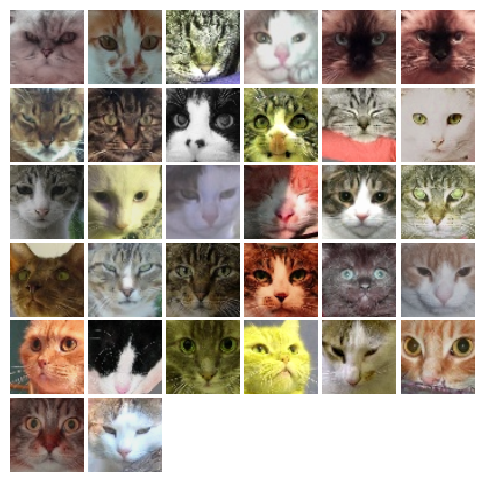

In [8]:
from gan.utils import show_images

imgs = next(iter(cat_loader_train))[0].numpy().squeeze()
show_images(imgs, color=True)

In [9]:
next(iter(cat_loader_train))[0].numpy().shape

(32, 3, 64, 64)

# Training 


Training regime is implemented in `gan/train.py`.

In [10]:
NOISE_DIM = 100
NUM_EPOCHS = 50
learning_rate = 0.001

### Train GAN

In [11]:
D = Discriminator().to(device)
G = Generator(noise_dim=NOISE_DIM).to(device)

In [12]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

In [13]:
# original gan
train(D, G, D_optimizer, G_optimizer, discriminator_loss, 
          generator_loss, num_epochs=NUM_EPOCHS, show_every=250,
          batch_size=batch_size, train_loader=cat_loader_train, device=device)


### Train LS-GAN

In [14]:
D = Discriminator().to(device)
G = Generator(noise_dim=NOISE_DIM).to(device)

In [15]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

In [16]:
# ls-gan
train(D, G, D_optimizer, G_optimizer, ls_discriminator_loss, 
          ls_generator_loss, num_epochs=NUM_EPOCHS, show_every=250,
          batch_size=batch_size, train_loader=cat_loader_train, device=device)